In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pickle
import bz2
import nltk
from wordcloud import WordCloud
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, roc_auc_score

In [ ]:
# Other necessary resources if not previously downloaded.
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('omw-1.4')

# Get and Preprocess Data

In [4]:
# Training data is compressed and in text format.
# Labels and reviews are in the same file, so this will seperate them.
def get_data(file):
    labels = []
    reviews = []
    for line in bz2.BZ2File(file):
        de = line.decode('utf-8')
        labels.append(int(de[9]) - 1)
        reviews.append(de[10:].strip())
    return np.array(labels), reviews

train_labels, train_reviews = get_data('train.ft.txt.bz2')
test_labels, test_reviews = get_data('test.ft.txt.bz2')

In [5]:
# Take a look at the data
print('Number of Reviews:\nTraining: {}\nTest: {}'.format(len(train_reviews), len(test_reviews)) + '\n')
print('Review:\n{}'.format(train_reviews[0]))
print('Label: {}'.format(test_labels[0]))

Number of Reviews:
Training: 3600000
Test: 400000

Review:
Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^
Label: 1


# Random Forest Classifier

In [6]:
# Data is too large, so let's truncate the data
# Training data
rev_train, rev_test, lab_train, lab_test = train_test_split(train_reviews, train_labels, test_size=0.998, random_state=20) # We now have 7,200 reviews to train the model.
print('Training Data: {}'.format(len(rev_train)))
# Test data
rev, rev_test, lab, lab_test = train_test_split(test_reviews, test_labels, test_size=0.01, random_state=20) # We now have 4,000 reviews to test the model.
print('Test Data: {}'.format(len(rev_test)))

Training Data: 7200
Test Data: 4000


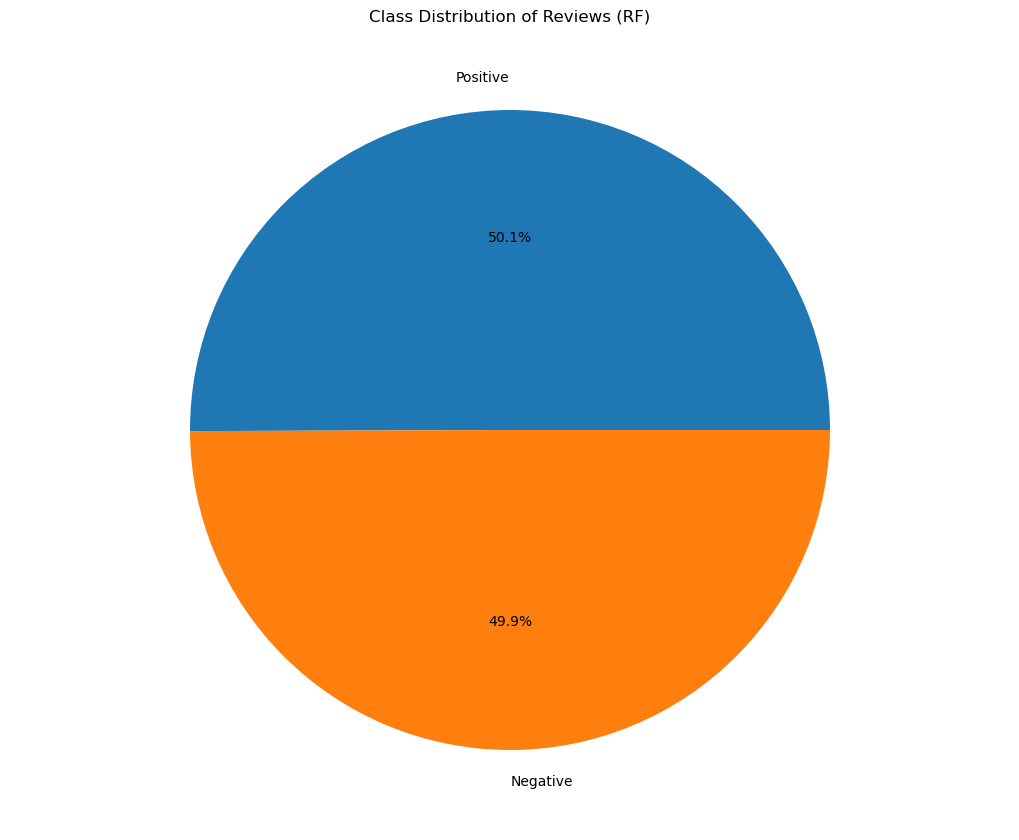

In [7]:
# Visualize the size of each class.
fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')

tr = []
tr.append(len([i for i in range(len(lab_train)) if lab_train[i] == 1]))
tr.append(len([i for i in range(len(lab_train)) if lab_train[i] == 0]))
cat = ['Positive', 'Negative']
ax.pie(tr, labels=cat, autopct='%1.1f%%')
ax.set_title('Class Distribution of Reviews (RF)')
plt.show()

In [8]:
# This funcion will preprocess the reviews by doing the following:
# Lemmatizing
# Tokenizing
# Remving stopwords
# Removing non-alpha characters
def clean_reviews(reviews):
    lem = nltk.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english')
    tokens = nltk.word_tokenize(reviews)
    lower = [word.lower() for word in tokens]
    no_stopwords = [word for word in lower if word not in stopwords]
    no_alpha = [word for word in no_stopwords if word.isalpha()]
    lemm = [lem.lemmatize(word) for word in no_alpha]
    clean = lemm
    return clean

In [9]:
# This function will work as a sort of pipeline for vectorizing reviews and extracting features.
def vectorize(data, vec):
    rev_vec = vec.transform(data)
    rev_array = rev_vec.toarray()
    return rev_array

In [18]:
# Vectorize training and test reviews.
vect = TfidfVectorizer(analyzer=clean_reviews)

X_vect = vect.fit(rev_train)
X_train = vectorize(rev_train, X_vect)
words = X_vect.get_feature_names()

X_test = vectorize(rev_test, vect)

tr_df = pd.DataFrame(X_vect.idf_, index=X_vect.get_feature_names(), columns=['IDF_Weights'])
tr_df = tr_df.sort_values('IDF_Weights', ascending=False)
tr_df.head(10)

C:\Users\gmart\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,IDF_Weights
útil,9.188828
grokdotcom,9.188828
remo,9.188828
grimacing,9.188828
grime,9.188828
grimly,9.188828
remixlike,9.188828
remixesof,9.188828
remixesandy,9.188828
reminiscing,9.188828


In [19]:
# Save TFIDF vectorizer
joblib.dump(vect, 'best_vectorizer.pkl')

['best_vectorizer.pkl']

In [20]:
# Create Random Forest classifier.
rf = RandomForestClassifier()
cv = cross_val_score(rf, X_train, lab_train, cv=10)

In [21]:
# See R-Squared scores.
print('All runs: {}'.format(cv))
print('Average score: {}'.format(cv.mean()))

All runs: [0.80833333 0.80277778 0.83888889 0.83472222 0.8375     0.8375
 0.84027778 0.82916667 0.85555556 0.825     ]
Average score: 0.8309722222222222


In [22]:
# Optimize hyperparameters with GridSearch
params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [20, 50, None],
}

gcv = GridSearchCV(rf, params).fit(X_train, lab_train)

In [23]:
# Print out GridSearch results
def gcv_results(results):
    print('Best Parameters: {}\n'.format(results.best_params_))
    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

gcv_results(gcv)

Best Parameters: {'max_depth': None, 'n_estimators': 200}

0.805 (+/-0.022) for {'max_depth': 20, 'n_estimators': 50}
0.815 (+/-0.019) for {'max_depth': 20, 'n_estimators': 100}
0.824 (+/-0.02) for {'max_depth': 20, 'n_estimators': 200}
0.812 (+/-0.017) for {'max_depth': 50, 'n_estimators': 50}
0.823 (+/-0.013) for {'max_depth': 50, 'n_estimators': 100}
0.828 (+/-0.02) for {'max_depth': 50, 'n_estimators': 200}
0.819 (+/-0.018) for {'max_depth': None, 'n_estimators': 50}
0.826 (+/-0.017) for {'max_depth': None, 'n_estimators': 100}
0.834 (+/-0.022) for {'max_depth': None, 'n_estimators': 200}


In [37]:
# Max Depth seems to irrelevant, so create models with different estimators.
rf1 = RandomForestClassifier(n_estimators=100).fit(X_train, lab_train)
rf2 = gcv.best_estimator_

In [38]:
# Test the models and print out results.
for forest in [rf1, rf2]:
    pred = forest.predict(X_test)
    print('Estimators: {} | A: {} R: {} P: {} R: {}'.format(forest.n_estimators, round(accuracy_score(lab_test, pred), 3), round(recall_score(lab_test, pred), 3), round(precision_score(lab_test, pred), 3), round(roc_auc_score(lab_test, pred), 3)))

Estimators: 100 | A: 0.828 R: 0.825 P: 0.832 R: 0.829
Estimators: 200 | A: 0.834 R: 0.833 P: 0.835 R: 0.834


Text(0.5, 1.0, 'Top 20 Features')

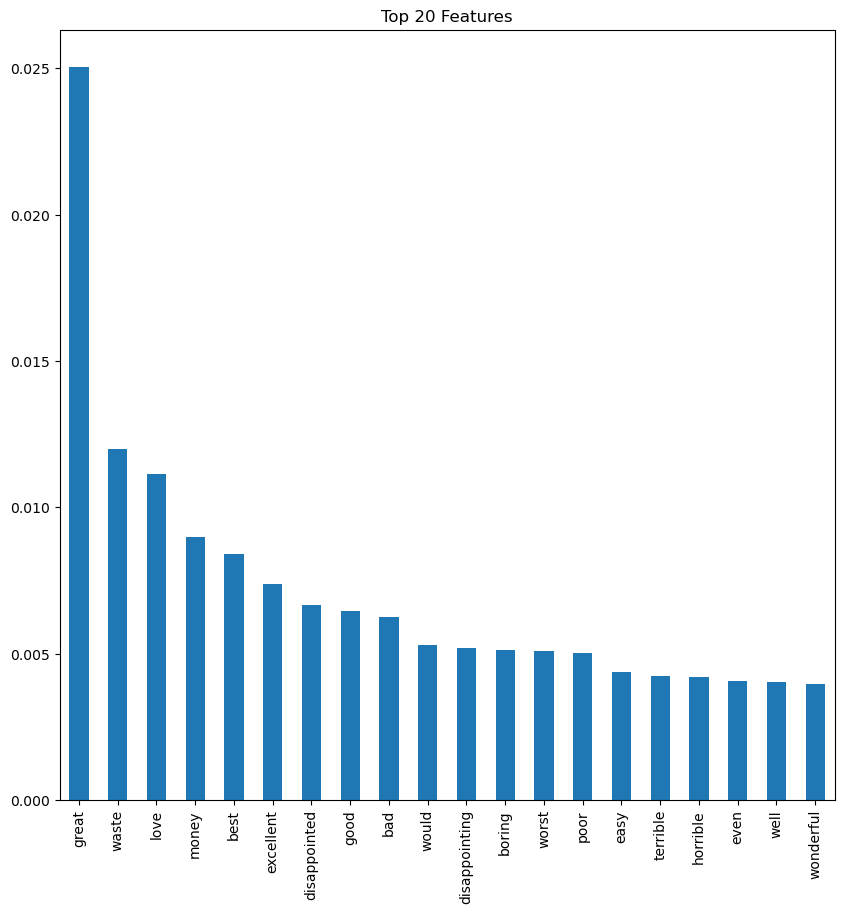

In [39]:
# Best model is the one with 200 estimators and no max_depth.
# Check the most important words.
feat_import = pd.Series(rf2.feature_importances_, index=words)
feat_import.nlargest(20).plot(kind='bar', figsize=(10,10))
plt.title('Top 20 Features')

In [40]:
# Save best model
joblib.dump(rf2, 'actual_best_rf.pkl')
joblib.dump(rf2, 'actual_best_rf.sav')

['actual_best_rf.sav']

# Convolutional Neural Net

In [43]:
import re
import tensorflow
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import save_model

In [44]:
# Data is too large, so let's truncate the data
# Training data
r_train, r_test, l_train, l_test = train_test_split(train_reviews, train_labels, test_size=0.95, random_state=20) # We now have 7,200 reviews to train the model.
print('Training Data: {}'.format(len(r_train)))
# Test data
rev, r_test, lab, l_test = train_test_split(test_reviews, test_labels, test_size=0.15, random_state=20) # We now have 4,000 reviews to test the model.
print('Test Data: {}'.format(len(r_test)))

Training Data: 180000
Test Data: 60000


In [45]:
# This function will process reviews to use with the keras tokenizer.
no_alpha = re.compile(r'[\W]')
no_ascii = re.compile(r'[^a-z0-1\s]')
def normalize_reviews(reviews):
    normalized_rev = []
    for text in reviews:
        lower = text.lower()
        no_punctuation = no_alpha.sub(r' ', lower)
        no_non_ascii = no_ascii.sub(r'', no_punctuation)
        normalized_rev.append(no_non_ascii)
    return normalized_rev
        
train_rev = normalize_reviews(r_train)
test_rev = normalize_reviews(r_test)

In [46]:
#Split the data.
train_rev, val_rev, train_lab, val_lab = train_test_split(train_rev, l_train, random_state=20, test_size=0.2)

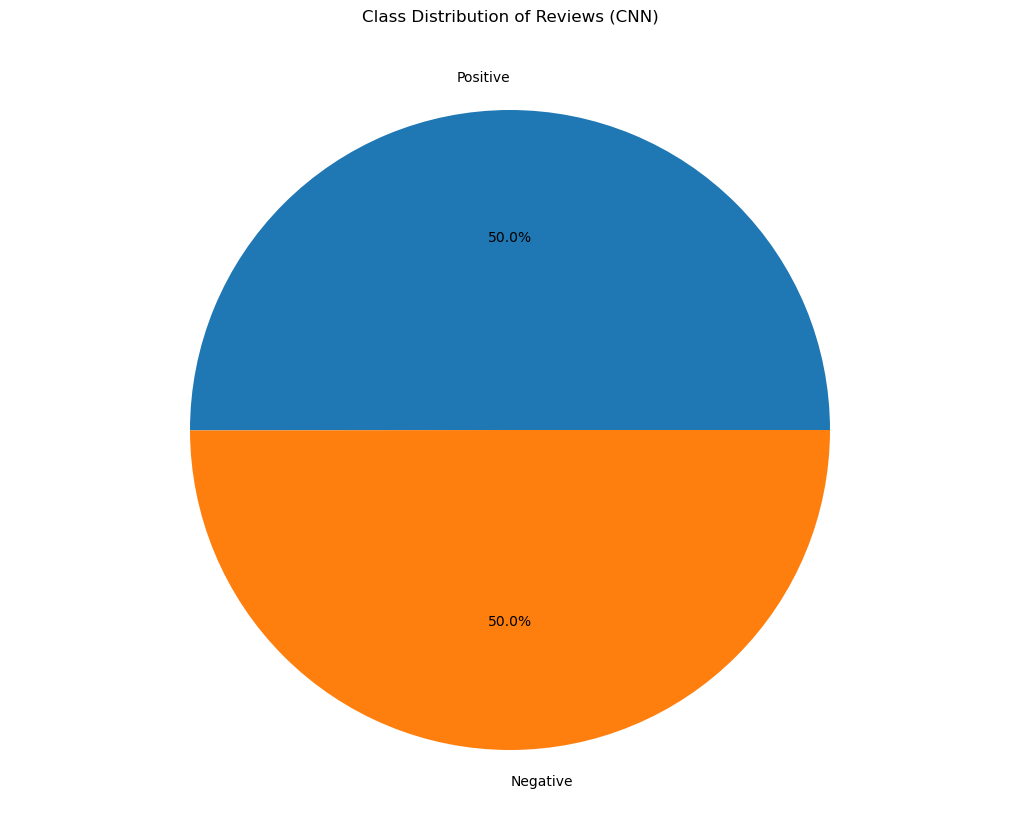

In [47]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')

tr = []
tr.append(len([i for i in range(len(l_train)) if l_train[i] == 1]))
tr.append(len([i for i in range(len(l_train)) if l_train[i] == 0]))
cat = ['Positive', 'Negative']
ax.pie(tr, labels=cat, autopct='%1.1f%%')
ax.set_title('Class Distribution of Reviews (CNN)')
plt.show()

In [48]:
# Run tokenizer
tokenizer = Tokenizer(num_words=12000)
tokenizer.fit_on_texts(train_rev)
train_rev = tokenizer.texts_to_sequences(train_rev)
val_rev = tokenizer.texts_to_sequences(val_rev)
test_rev = tokenizer.texts_to_sequences(test_rev)

In [49]:
# Padding to make sure all sentences are equal in length.
length = max(len(text) for text in train_rev)
train_rev = pad_sequences(train_rev, maxlen=length)
val_rev = pad_sequences(val_rev, maxlen=length)
test_rev = pad_sequences(test_rev, maxlen=length)

In [50]:
def pad(token, length):
    if not length:
        length = max(len(text) for text in token)
    else:
        length = length
    
    tokens = pad_sequences(token, maxlen=length)
    return tokens

In [51]:
# Build neural net model and fit it with our validation data.
sequences = layers.Input(shape=(length,))
embedded = layers.Embedding(12000, 64)(sequences)

x = layers.Conv1D(64, 3, activation='relu')(embedded)
x = layers.BatchNormalization()(x)
x = layers.MaxPool1D(3)(x)
x = layers.Conv1D(64, 5, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool1D(5)(x)
x = layers.Conv1D(64, 5, activation='relu')(x)
x = layers.GlobalMaxPool1D()(x)
x = layers.Flatten()(x)
x = layers.Dense(100, activation='relu')(x)

predictions = layers.Dense(1, activation='sigmoid')(x)
model = models.Model(inputs=sequences, outputs=predictions)
model.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=['binary_accuracy'])

In [55]:
# Train model and validate it.
model.fit(train_rev, train_lab, batch_size=128, epochs=4, validation_data=(val_rev, val_lab),)

Epoch 1/4
1125/1125 [==============================] - 45s 40ms/step - loss: 0.0699 - binary_accuracy: 0.9764 - val_loss: 0.2740 - val_binary_accuracy: 0.9236
Epoch 2/4
1125/1125 [==============================] - 44s 39ms/step - loss: 0.0517 - binary_accuracy: 0.9830 - val_loss: 0.2965 - val_binary_accuracy: 0.9165
Epoch 3/4
1125/1125 [==============================] - 44s 39ms/step - loss: 0.0410 - binary_accuracy: 0.9866 - val_loss: 0.3364 - val_binary_accuracy: 0.9175
Epoch 4/4
1125/1125 [==============================] - 45s 40ms/step - loss: 0.0336 - binary_accuracy: 0.9888 - val_loss: 0.4502 - val_binary_accuracy: 0.9165


In [56]:
# Test our model and evaluate performance
preds = model.predict(test_rev)
print('Accuracy score: {:0.4}'.format(accuracy_score(l_test, 1 * (preds > 0.5))))
print('Precision score: {:0.4}'.format(precision_score(l_test, 1 * (preds > 0.5))))
print('Recall score: {:0.4}'.format(recall_score(l_test, 1 * (preds > 0.5))))
print('F1 score: {:0.4}'.format(f1_score(l_test, 1 * (preds > 0.5))))
print('ROC AUC score: {:0.4}'.format(roc_auc_score(l_test, preds)))

1875/1875 [==============================] - 5s 3ms/step
Accuracy score: 0.9143
Precision score: 0.9036
Recall score: 0.9272
F1 score: 0.9152
ROC AUC score: 0.9704


In [57]:
# Save model and tokenizer
save_model(model, 'best_CNN.h5')
pickle.dump(tokenizer, open("best_tokenizer.pickle", "wb"), protocol=pickle.HIGHEST_PROTOCOL)

In [58]:
def cnn_pred(preds):
    pr = np.transpose(preds)[0]
    pr = list(map(lambda x: 0 if x < 0.5 else 1, pr))
    return pr

# Scraping Amazon Reviews

In [59]:
import requests
from bs4 import BeautifulSoup
import math

In [60]:
def get_url():
    url = input('Product URL:')
    spl = url.split('/')
    id = spl[spl.index('dp') + 1]
    url = f'https://www.amazon.com/product-reviews/{id}/ref=cm_cr_arp_d_viewopt_srt?ie=UTF8&reviewerType=all_reviews&sortBy=recent&pageNumber='
    return url

def get_reviews(url):
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:108.0) Gecko/20100101 Firefox/108.0', 'Accept-Language': 'en-US, en;q=0.5'}
    res = requests.get(url, headers=headers)
    soup = BeautifulSoup(res.text, 'html.parser')

    while True:
        try:
            rev_num = soup.find('div', class_='a-row a-spacing-base a-size-base').get_text().strip()
            break
        except:
            pass
    
    rev_num = int(rev_num.split(' ')[3].replace(',', ''))
    page_num = math.ceil(rev_num/10) + 1

    title = []
    reviews = []
    ratings = []
    date = []

    if rev_num > 1000:
        for page in np.arange(1,101):
            nurl = url + str(page)
            res = requests.get(nurl, headers=headers)
            soup = BeautifulSoup(res.text, 'html.parser')

            for item in soup.select('i[data-hook=review-star-rating]'):
                text = item.get_text()
                ratings.append(text)

            for item in soup.select('a[data-hook=review-title]'):
                text = item.get_text().replace('\n', '').strip()
                title.append(text)

            for item in soup.select('span[data-hook=review-body]'):
                text = item.get_text().replace('\n', '').strip()
                reviews.append(text)

            for item in soup.select('span[data-hook=review-date]'):
                text = item.get_text().strip().split(' ')[6:]
                text = ' '.join(text)
                date.append(text)

            if not soup.select('i[data-hook=review-star-rating]'):
                break
    else:
        for page in np.arange(1,page_num):
            nurl = url + str(page)
            res = requests.get(nurl, headers=headers)
            soup = BeautifulSoup(res.text, 'html.parser')

            for item in soup.select('i[data-hook=review-star-rating]'):
                text = item.get_text()
                ratings.append(text)

            for item in soup.select('a[data-hook=review-title]'):
                text = item.get_text().replace('\n', '').strip()
                title.append(text)

            for item in soup.select('span[data-hook=review-body]'):
                text = item.get_text().replace('\n', '').strip()
                reviews.append(text)
            
            for item in soup.select('span[data-hook=review-date]'):
                text = item.get_text().strip().split(' ')[6:]
                text = ' '.join(text)
                date.append(text)

            if not soup.select('i[data-hook=review-star-rating]'):
                break

    if len(title) != len(reviews):
        reviews = reviews[:len(title)]

    df = pd.DataFrame({'Title': title, 'Rev': reviews, 'Stars': ratings, 'Date': pd.to_datetime(date)})
    
    df['Reviews'] = df['Title'] + '. ' + df['Rev']
    df = df.drop(['Rev', 'Title'], axis=1)

    for c, r in enumerate(df['Stars']):
        df['Stars'].values[c] = df['Stars'].values[c][0]

    for c, col in enumerate(df['Reviews']):
        if 'The media could' in col:
            ind = col.index('The media could')
            df['Reviews'].values[c] = col[:ind] + col[ind+47:]
        else:
            pass
    
    return df

# Get Amazon Reviews and Apply Models

In [61]:
# Scrape an amazon product page for reviews.
url = get_url()
amzn = get_reviews(url)

Product URL: https://www.amazon.com/Oral-B-iO-Electric-Toothbrush-Brush/dp/B088CK6XJ4/ref=cm_cr_arp_d_product_top?ie=UTF8


In [62]:
# Preprocess amazon reviews and get predictions for the Random Forest Classifier.
rf_array = vectorize(amzn['Reviews'], vect)
rf_preds = rf2.predict(rf_array)

In [63]:
# Preprocess amazon reviews and get predictions for the Convolutional Neural Net.
norm_rev = normalize_reviews(amzn['Reviews'])
token = tokenizer.texts_to_sequences(norm_rev)
cnn_revs = pad(token, None)

cnn_preds = model.predict(cnn_revs)
cnn_preds = cnn_pred(cnn_preds)

20/20 [==============================] - 0s 9ms/step


In [64]:
# Append prediction back to original dataframe
amzn['RF_Predictions'] = rf_preds
amzn['CNN_Predictions'] = cnn_preds
amzn.head(10)

,Stars,Reviews,RF_Predictions,CNN_Predictions
0,5,I’m happy with the item. Love the color the po...,1,1
1,1,Defective Appliance. The tooth brush just brok...,0,0
2,5,Replacing or refund. Started to make grinding ...,0,0
3,1,Worked great until it didn't after only 3 mont...,0,0
4,4,Super fancy toothbrush that does a great job! ...,1,1
5,1,Don't understand how it doesn't work with iO 6...,1,0
6,1,Dont buy!. Ive used device for a month and sta...,0,0
7,2,"Used. Package was opened before, the sealer we...",0,1
8,3,"Not multi-user friendly, and no case to store ...",0,0
9,4,2 Years Later The Motion Stopped Working. My h...,0,0


In [65]:
# Get a list of the positive and negative words from each review.
amzn['clean']=amzn['Reviews'].map(clean_reviews)
amzn['clean_text']=amzn['clean'].apply(lambda x: " ".join([str(word) for word in x]))

rf_pos = ' '.join(amzn[amzn.RF_Predictions==1]['clean_text'].values)
rf_neg = ' '.join(amzn[amzn.RF_Predictions==0]['clean_text'].values)

cnn_pos = ' '.join(amzn[amzn.CNN_Predictions==1]['clean_text'].values)
cnn_neg = ' '.join(amzn[amzn.CNN_Predictions==0]['clean_text'].values)

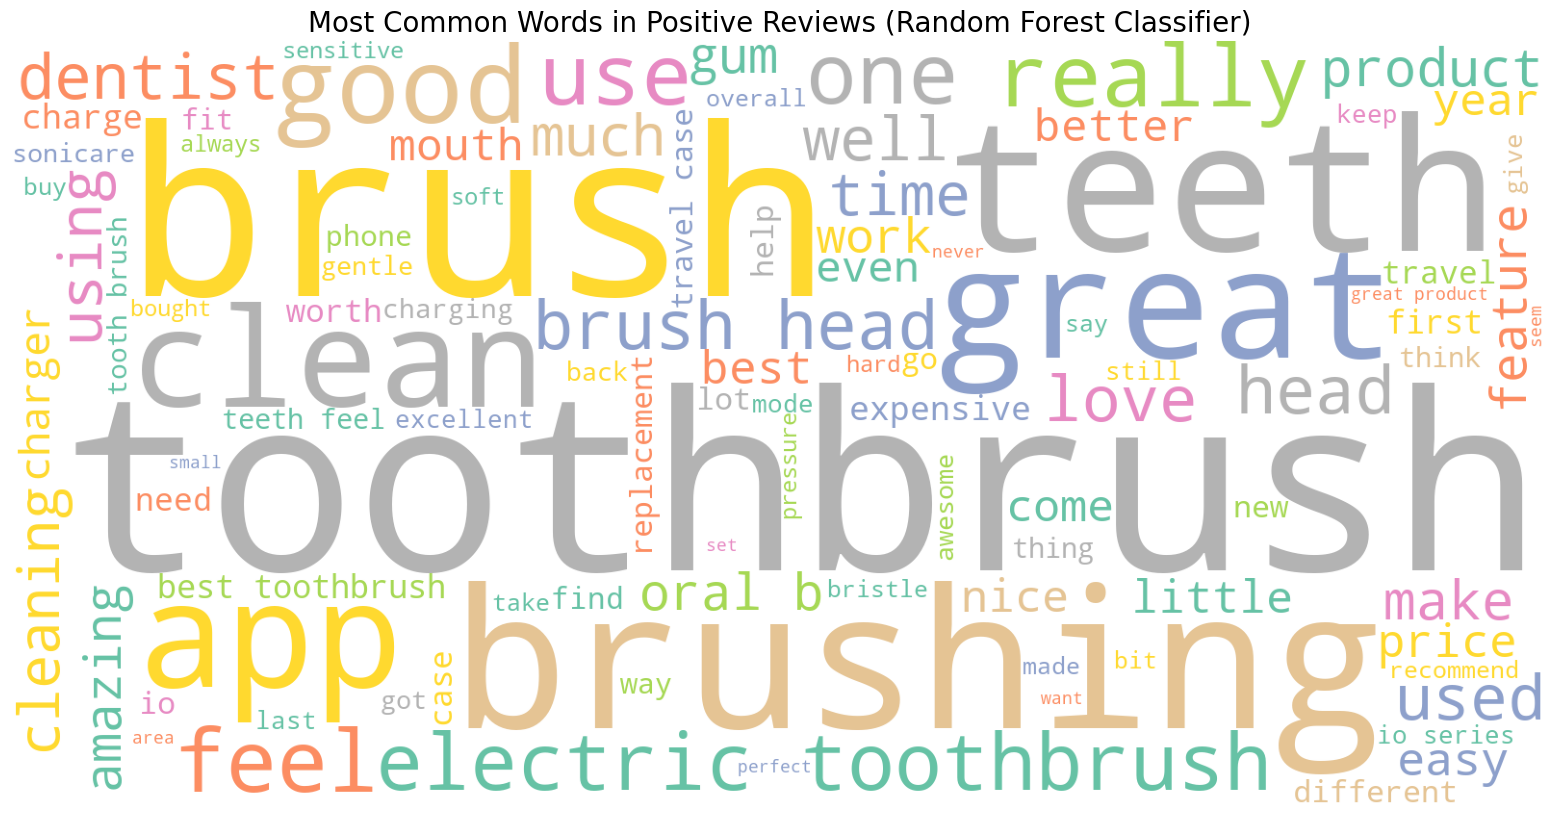

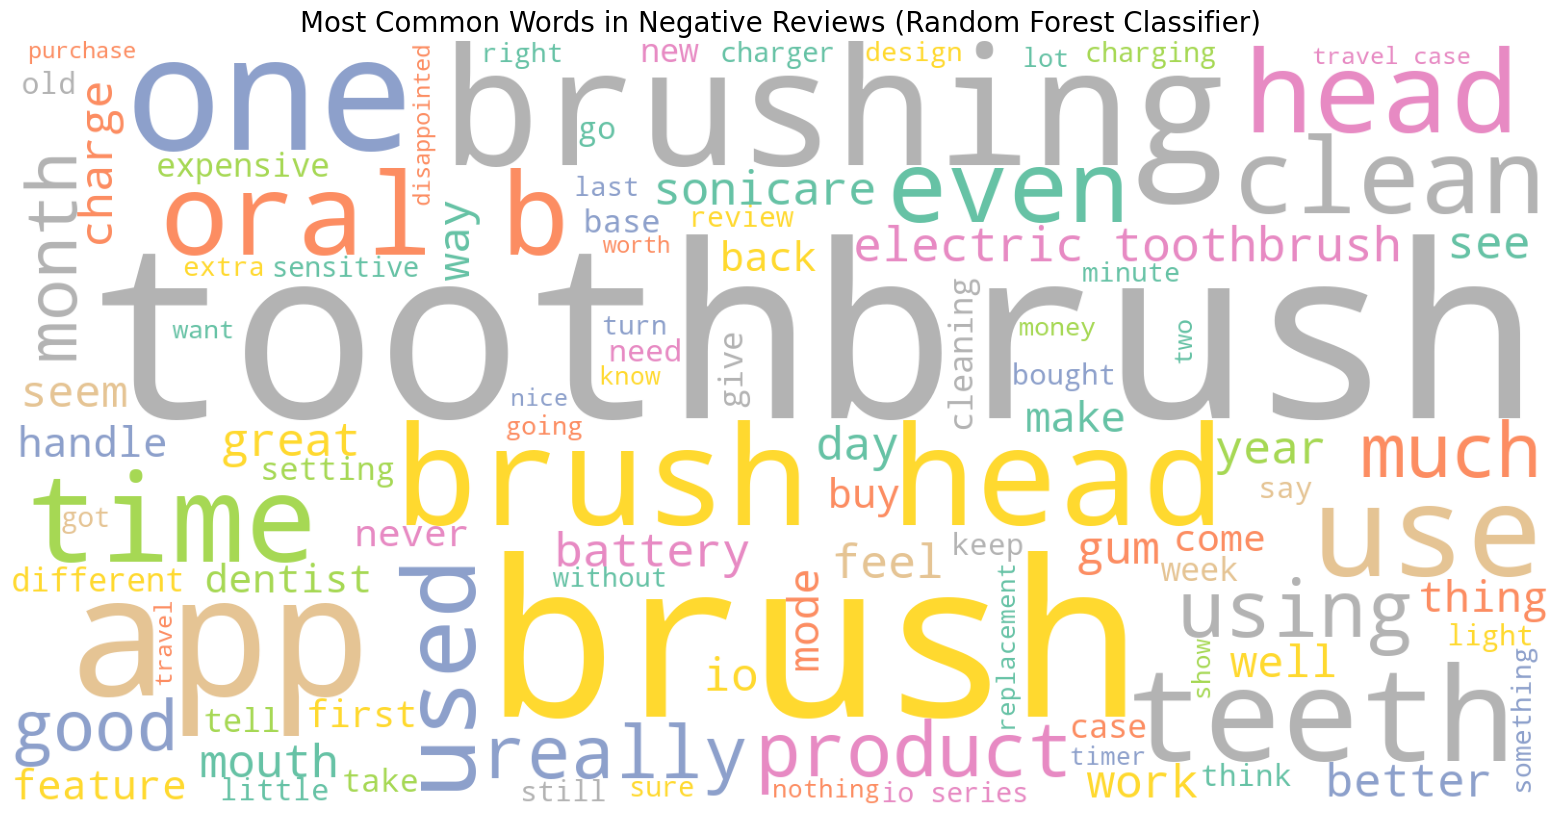

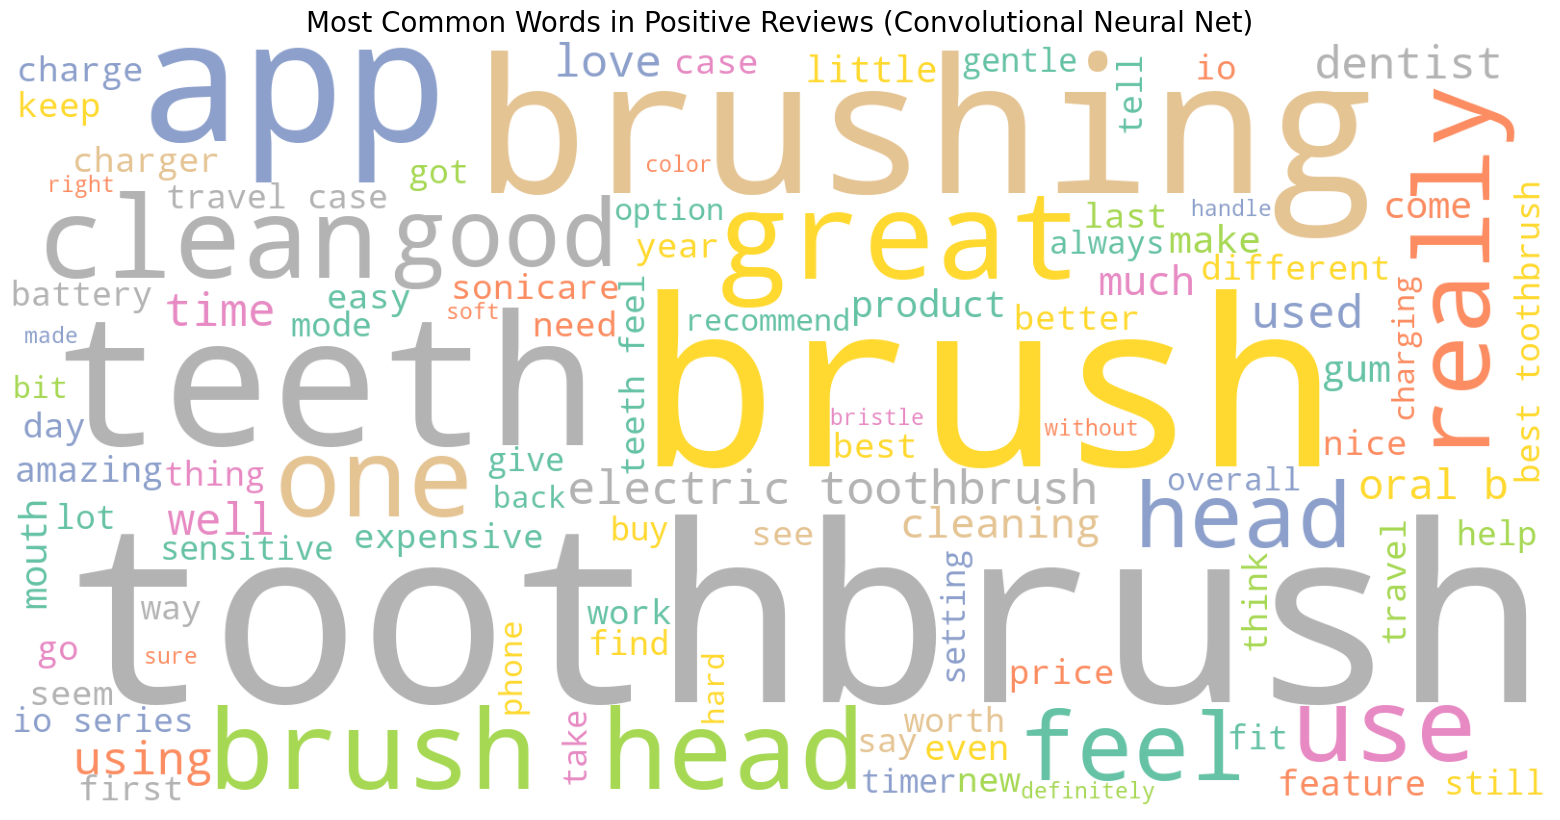

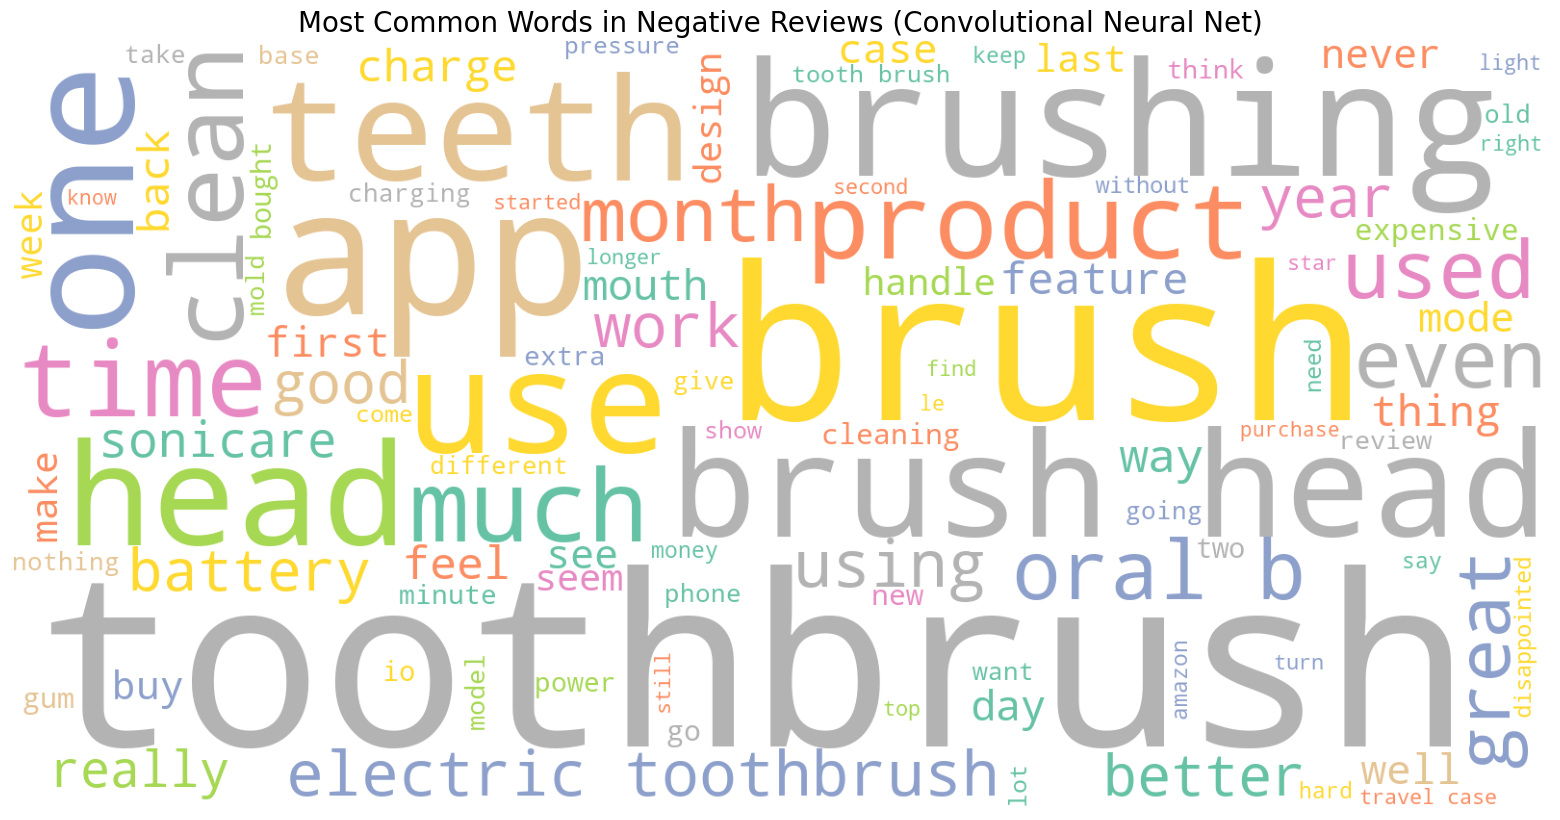

In [66]:
# Make wordclouds based on the review sentiment.
def generate_wordcloud(words, sentiment, classifier):
    plt.figure(figsize=(20,10))
    wc = WordCloud(background_color="white", max_words=100, width=1600, height=800)
    wc.generate(words)
    words = wc.words_
    plt.title('Most Common Words in {} Reviews ({})'.format(sentiment, classifier), fontsize=20)
    plt.imshow(wc.recolor(colormap='Set2', random_state=20))
    plt.axis('off')
    c = []
    
    for l in classifier.split(' '):
        c.append(l[0])
    c = ''.join(c)
    s = sentiment[:3].lower()
    
    wc.to_file('{}_{}.png'.format(c, s))
    return words

rf_poswords = generate_wordcloud(rf_pos, 'Positive', 'Random Forest Classifier')
rf_negwords = generate_wordcloud(rf_neg, 'Negative', 'Random Forest Classifier')

cnn_poswords = generate_wordcloud(cnn_pos, 'Positive', 'Convolutional Neural Net')
cnn_negwords = generate_wordcloud(cnn_neg, 'Negative', 'Convolutional Neural Net')

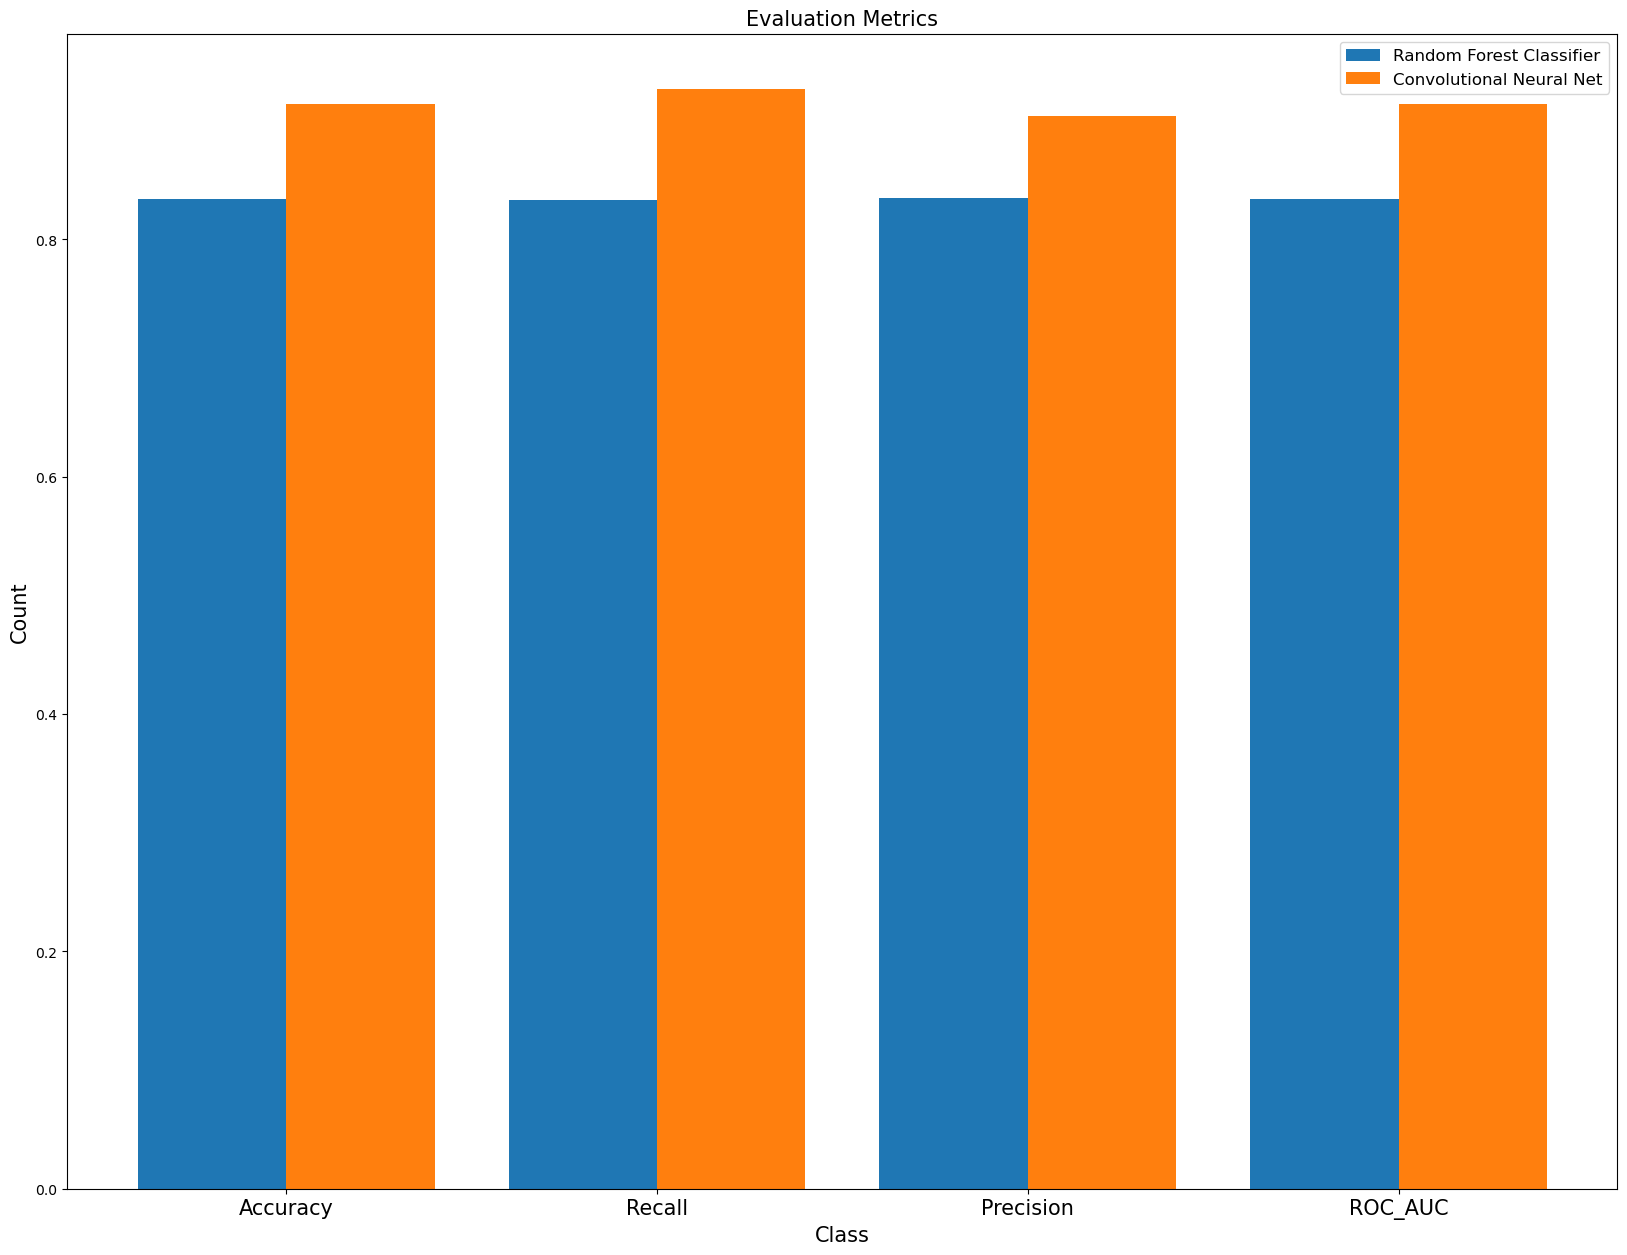

In [67]:
# Plot and compare classification of reviews between the two models.
plt.figure(figsize=(20,15))
X = ['Accuracy','Recall', 'Precision', 'ROC_AUC']
r = [round(accuracy_score(lab_test, pred), 3), round(recall_score(lab_test, pred), 3), round(precision_score(lab_test, pred), 3), round(roc_auc_score(lab_test, pred), 3)]
c = [round(accuracy_score(l_test, 1 * (preds > 0.5)), 3), round(recall_score(l_test, 1 * (preds > 0.5)), 3), round(precision_score(l_test, 1 * (preds > 0.5)), 3), round(roc_auc_score(l_test, 1 * (preds > 0.5)), 3)]

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, r, 0.4, label = 'Random Forest Classifier')
plt.bar(X_axis + 0.2, c, 0.4, label = 'Convolutional Neural Net')


plt.xticks(X_axis, X, fontsize=15)
plt.xlabel("Class", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.title("Evaluation Metrics", fontsize=15)
plt.legend(prop={'size': 12})
plt.show()